In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
!pip install yfinance
import yfinance as yf

  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=978e59baafc39d2951a2bc6084537717b492e5d136c954de023b6a8b685ae3d9
  Stored in directory: /Users/germanarutunov/Library/Caches/pip/wheels/f2/b5/2c/59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking


## Чувствительности
Зависимость цены актива $P$ от двух риск-факторов $X,\,Y$  моделируется функцией
$$
P(x,\,y) = \frac{x - F}{(1+y)^2},
$$
$F=55$. Факторы $X, Y$ нестационарны и положительны, так что имеет смысл переходить к доходностям. Текущие значения риск-факторов: $X=50,\,y=0.05$. Найдите текущие чувствительности доходности актива к доходностям этих двух факторов.


1. Переходим к доходностям (или разностям). Факторы риска -- доходности $\frac{X-X_0}{X_0}$ и $\frac{Y-Y_0}{Y_0}$. Вместо цены -- тоже доходность: $\frac{P-P_0}{P_0}$.

2. Считаем чувствительность:
$$
\frac{\partial\left(\frac{P(x,y)-P(x_0,y_0)}{P(x_0,y_0)}\right)}{\partial\left(\frac{x-x_0}{x_0}\right)}=\frac{\partial P(x,y)}{\partial x}\cdot\frac{x_0}{P(x_0,y_0)}
$$

In [2]:
!pip install autograd==1.3

In [3]:
F = 55
x0 = 50
y0 = 0.05

def price_asset(x, y):
    return (x - F) / (1 + y) ** 2

def return_asset(ret_x, ret_y):
    x1 = x0 * (1 + ret_x)
    y1 = y0 * (1 + ret_y)
    return price_asset(x1, y1) / price_asset(x0, y0) - 1

from autograd import grad
grad(return_asset, [0, 1])(0.0, 0.0)

(array(-10.), array(-0.0952381))

In [4]:
(50*((1+0.05)**2)/(-5))*(1/((1+0.05+0.00000001)**2))

-9.999999809523814

## Факторы
Портфель состоит из одной акции JP Morgan Chase, двух акций Microsoft и трёх акций Pfizer. Рассматривается два риск-фактора -- индекс S&P 500 и курс евро к доллару. Временной период -- с 1 января по 31 декабря 2020 года.

In [5]:
tickers = {
    "JPMorgan": "JPM",
    "Microsoft": "MSFT",
    "Pfizer": "PFE",
    "SnP": "^GSPC",
    "FX": "EURUSD=X"
}
portfolio = {
    "JPMorgan": 1,
    "Microsoft": 2,
    "Pfizer": 3
}
factors = ["SnP", "FX"]
portfolio_composition = pd.Series(portfolio)
portfolio_composition

JPMorgan     1
Microsoft    2
Pfizer       3
dtype: int64

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,JPMorgan,Microsoft,Pfizer,SnP,FX
Date,,,,,
2019-12-31,129.478256,154.430435,34.109665,3230.780029,1.120230
2020-01-02,131.047989,157.289856,34.074844,3257.850098,1.122083
2020-01-03,129.318604,155.331345,33.892025,3234.850098,1.117144
2020-01-06,129.215805,155.732864,33.848488,3246.280029,1.116196
2020-01-07,127.019043,154.312912,33.735317,3237.179932,1.119799
...,...,...,...,...,...
2020-12-23,120.386833,218.730469,35.758362,3690.010010,1.218665
2020-12-24,119.857414,220.442535,35.595997,3703.060059,1.219141
2020-12-28,120.646706,222.629669,35.166210,3735.360107,1.220510


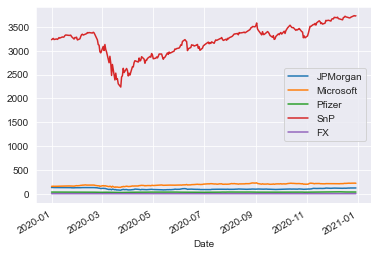

In [6]:
quote_data = pd.DataFrame(
    {
        factor: yf.download(ticker, "2020-01-01", "2020-12-31")['Adj Close']
        for factor, ticker in tickers.items()
    }
)
quote_data.dropna(inplace=True)
quote_data.plot()
quote_data

<AxesSubplot:xlabel='Date'>

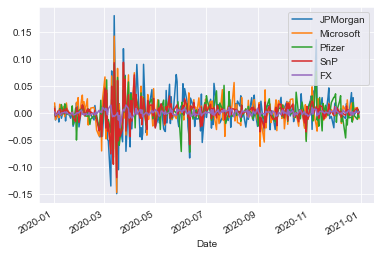

In [7]:
returns = quote_data.pct_change().dropna()
returns.plot()

In [8]:
from statsmodels.formula.api import ols
ols("Microsoft ~ SnP + FX - 1", returns).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Microsoft   R-squared (uncentered):                   0.774
Model:                            OLS   Adj. R-squared (uncentered):              0.772
Method:                 Least Squares   F-statistic:                              427.0
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                    2.36e-81
Time:                        21:39:08   Log-Likelihood:                          733.31
No. Observations:                 252   AIC:                                     -1463.
Df Residuals:                     250   BIC:                                     -1456.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SnP            1.1248      0.039     29.191      0.000       1.049       1.201
FX            -0.1589      0.175     -0.906      0.366      -0.504       0.186
==============================================================================
Omnibus:                        6.616   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                7.492
Skew:                           0.251   Prob(JB):                       0.0236
Kurtosis:                       3.680   Cond. No.                         4.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Найдите чувствительности всех инструментов ко всем риск-факторам
(hint: `statsmodels.api` might be better suited for the task)

In [9]:
df = pd.DataFrame()
for key in portfolio.keys():
    model = ols(f"{key} ~ SnP + FX - 1", returns).fit()
    df[key] = model.params
df=df.T


### Найдите VaR на уровне 99% дельта-нормальным методом по этому портфелю

In [10]:
current_stock_prices = quote_data[portfolio_composition.index].loc[quote_data.index.max()]
print(current_stock_prices)

# Относительные расчёты (единицы измерения -- процентные доли в портфеле и проценты доходности)

portfolio_price = portfolio_composition @ current_stock_prices
portfolio_weights = (portfolio_composition * current_stock_prices) / portfolio_price

print(portfolio_weights)
portfolio_sensitivities = portfolio_weights @ df
portfolio_sensitivities


JPMorgan     120.665970
Microsoft    219.383621
Pfizer        35.089802
Name: 2020-12-30 00:00:00, dtype: float64
JPMorgan     0.181534
Microsoft    0.660096
Pfizer       0.158371
dtype: float64


SnP    1.084973
FX    -0.209001
dtype: float64

In [11]:
# Абсолютные расчёты: единицы измерения -- доллары и штуки акций
portfolio_dollar_composition = portfolio_composition * current_stock_prices
print(portfolio_dollar_composition)

portfolio_dollar_sensitivities = portfolio_dollar_composition @ df
portfolio_dollar_sensitivities

JPMorgan     120.665970
Microsoft    438.767242
Pfizer       105.269405
dtype: float64


SnP    721.184148
FX    -138.923190
dtype: float64

In [12]:
w = portfolio_sensitivities

In [13]:
w.T @ returns[['SnP', 'FX']].cov() @ w

0.0005533120151891114

In [14]:
ss.norm.ppf(0.99)

2.3263478740408408

In [15]:
np.sqrt(w.T @ returns[['SnP', 'FX']].cov() @ w)*ss.norm.ppf(0.99)

0.05472171610647281

In [16]:
np.sqrt(w.T @ returns[['SnP', 'FX']].cov() @ w)*ss.norm.ppf(0.99) * portfolio_price

36.37366793801346

### Найдите VaR на уровне 99% по этому портфелю историческим методом

In [17]:
def calculate_VaR_HS(returns, alpha):
    return -np.percentile(returns.values, (1 - alpha) * 100, method="inverted_cdf")


In [18]:
calculate_VaR_HS(returns[factors] @ w, 0.99)

0.08544484876789736

## Задача хеджирования
Дано: чувствительность доходности портфеля: 0.5 к S&P и -0.3 к нефти.

2 хеджирующих инструмента: фьючерс на S&P: чувствительность к S&P -- 1.04, фьючерс на нефть: чувствительность к индексу -0.1 и к нефти 0.95.

Найти состав хеджирующего портфеля: $x$ фьючерсов на S&P и $y$ фьючерсов на нефть.

$$
\begin{cases}
0.5 + 1.04x - 0.1y = 0\\
-0.3 + 0.95y=0
\end{cases},
$$
$$x, y - \text{доли стоимости активов}$$

### А теперь то же самое, но в штуках
Пусть портфель стоит 10 млн, а номиналы обоих фьючерсов -- по 100 тыс.

Дано: чувствительность цены портфеля в млн. долларов: 5 к S&P и -3 к нефти.

2 хеджирующих инструмента: фьючерс на S&P: чувствительность к S&P -- 104,000 долларов, фьючерс на нефть: чувствительность к индексу -10,000 долларов и к нефти 95,000 долларов.

Найти состав хеджирующего портфеля: $x$ фьючерсов на S&P и $y$ фьючерсов на нефть.

## Хеджирование
Портфель имеет чувствительности в 15 млн и 20 млн к риск-факторам A и B.
Дана матрица ковариаций доходностей факторов A и B:

| |A|B|
|:-|:-:|:-:|
|A|0.01|0.005|
|B|0.005|0.03|

VaR на уровне 99% оценивают дельта-нормальным методом. Лимит на VaR равен 5 млн. Захеджировать портфель инструментом с чувствительностями 1 млн и -2 млн соответственно -- так, чтобы уложиться в лимит.

In [19]:
ab = pd.DataFrame([[0.01, 0.005],[0.005, 0.03]], columns = ["A", "B"], index = ["A", "B"])
w = np.array([15,20])
a = np.array([1,-2])
x= -(a.T @ ab @ w)/(a.T @ ab @ a)
x

10.0

Пусть $s$ -- вектор чувствительностей портфеля, $a$ -- чувствительности инструмента, $x$ -- количество инструмента в хеджирующем портфеле.
$$
\sigma^2=(s + a\cdot x)^T\Sigma(s+a\cdot x)\to\min
$$
$$
a^T\Sigma a\cdot x^2 + 2a^T\Sigma s \cdot x\to\min
$$
$$
x = -\frac{a^T\Sigma s}{a^T\Sigma a}
$$

### Дюрация
$$\frac{\partial P}{\partial \Delta r}=-D\cdot P$$

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc69f171-f4bb-4c21-8857-3bf9aef78ad4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>